## Análise da votação de preposições

In [1]:
import pandas as pd
import pandasql as ps
import numpy as np

In [2]:
ano = '2019'
dfVotosParlamentares = pd.read_csv('dados/votos_2019.csv', sep=";", encoding="utf-8")
dfVotosParlamentares.head()

,CodSessao,Data,IdParlamentar,ObjVotacao,Parlamentar,Partido,Proposicao,Uf,Voto,Ano
0,16828,5/6/2019,141417,EMENDA AGLUTINATIVA Nº 1,Edio Lopes,PL,PEC 70 2011,RR,Sim,2019
1,16828,5/6/2019,204465,EMENDA AGLUTINATIVA Nº 1,Haroldo Cathedral,PSD,PEC 70 2011,RR,Sim,2019
2,16828,5/6/2019,178959,EMENDA AGLUTINATIVA Nº 1,Hiran Gonçalves,PP,PEC 70 2011,RR,Sim,2019
3,16828,5/6/2019,160531,EMENDA AGLUTINATIVA Nº 1,Jhonatan de Jesus,PRB,PEC 70 2011,RR,-,2019
4,16828,5/6/2019,204468,EMENDA AGLUTINATIVA Nº 1,Joenia Wapichana,REDE,PEC 70 2011,RR,Sim,2019


In [3]:
from pandasql import sqldf

def getQuery(q):
    pysqldf = lambda q: sqldf(q, globals())
    return pysqldf(q)


### Pré Processamento

Diante da crise política de 2014, vários partidos mudaram de nome, símbolo e ideologia, tanto para atrair eleitores para as eleições de 2018, como também para se esquivar dos casos de corrupção envolvendo políticos desses partidos. Os nomes foram alterados, em muitos casos, para slogans, em vez de siglas. Também caiu a palavra "partido" em alguns casos de renomeação.

In [4]:
# Ajustando siglas de partidos
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PTN', 'PODEMOS', 'Podemos'], 'PODE')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PTDOB', 'PTdoB', 'Avante'], 'AVANTE')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PEN', 'PATRIOTA', 'Patriota'], 'PATRI')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PMDB'], 'MDB')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PFL'], 'DEM')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PSDC'], 'DC')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PR'], 'PL')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PCdoB'], 'PCDOB')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PBR', 'REPUBLICAN', 'Republican'], 'REPUBLICANOS')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PPS'], 'CIDADANIA')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['SOLIDARIED', 'SOLIDARIEDAD', 'Solidariedad', 'Solidaried'], 'SOLIDARIEDADE')

### Análise dos dados

In [5]:
dfVotosParlamentares.groupby('Voto').count()

,CodSessao,Data,IdParlamentar,ObjVotacao,Parlamentar,Partido,Proposicao,Uf,Ano
Voto,,,,,,,,,
-,484677,484677,484677,484677,484677,484677,484677,484677,484677
Abstenção,5723,5723,5723,5723,5723,5723,5723,5723,5723
Art.17,4061,4061,4061,4061,4061,4061,4061,4061,4061
Não,824171,824171,824171,824171,824171,824171,824171,824171,824171
Obstrução,148307,148307,148307,148307,148307,148307,148307,148307,148307
Sim,783361,783361,783361,783361,783361,783361,783361,783361,783361


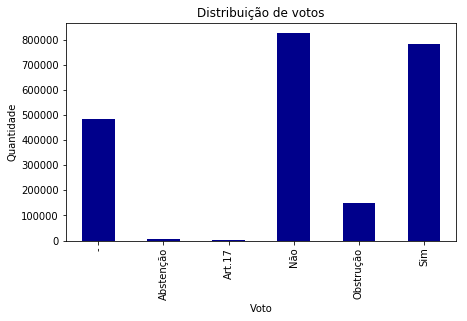

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
votos_tipo = dfVotosParlamentares.groupby('Voto').count().Partido
votos_tipo.plot(kind='bar', figsize=(7,4), grid=False, rot=90, color='darkblue')

plt.title('Distribuição de votos')
plt.xlabel('Voto')
plt.ylabel('Quantidade')
plt.show()

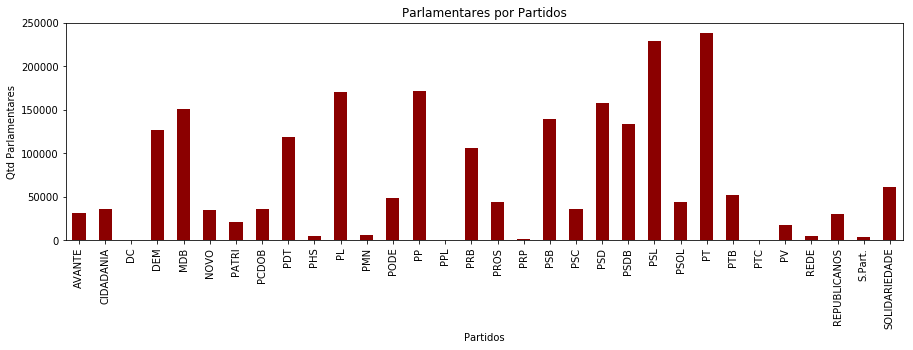

In [7]:
votos_partido = dfVotosParlamentares.groupby('Partido').count().Voto
votos_partido.plot(kind='bar', figsize=(15,4), grid=False, rot=90, color='darkred')

plt.title('Parlamentares por Partidos')
plt.xlabel('Partidos')
plt.ylabel('Qtd Parlamentares')
plt.show()

Verificando a quantidade de votantes por partido

In [8]:
df_analise = getQuery("SELECT DISTINCT Partido, Parlamentar from dfVotosParlamentares")
partido_parlamentar = getQuery("SELECT Partido, COUNT(*) AS Qtd_Parlamentares FROM df_analise GROUP BY Partido ORDER BY 2 DESC") 
partido_parlamentar.head()

,Partido,Qtd_Parlamentares
0,MDB,134
1,PT,134
2,PSDB,108
3,DEM,103
4,PP,100


### Cálculo da Coalisão Partidária através do Índice Rice

<p>Para medir a coesão partidária com base na análise das votações nominais será utilizado o Método de Rice (1925), já usado diversas vezes por vários estudiosos, muitos dos quais presentes na bibliografia.</p>
<p>O Índice Rice consiste em um cálculo simples que subtrai os votos sim e não, depois divididos pelo total de votos, excluindo as abstenções. Em um exemplo simples: se um partido A tiver 12 votos sim em um dada votação e 4 votos não, o cálculo ficará dessa forma: 12-4/16. O Índice Rice desse partido ficaria em 0,5. Quanto mais perto de 1,0, mais coeso o partido é; quanto mais próximo de 0, mais dividido.</p>
<p>Embora seja mais comum o cálculo da coesão para partidos políticos, outros grupos, como as frentes parlamentares, também podem ter sua medição a partir da metodologia anteriormente explicitada. Segundo o próprio Stuart Rice (1925), criador do índice, o cálculo foi elaborado para aferir coesão de grupos legislativos, não obrigatoriamente de partidos políticos. A importância de medir a coesão partidária a partir das votações nominais é justificada pelo autor quando afirma que “the most tangible and measurable units of political behavior are
votes” (Rice, 1925: 60).</p> 

Um problema que é frequentemente lembrado em estudos de disciplina partidária é que as votações são analisadas em conjunto, mas não apresentam o mesmo grau de controvérsia. Muitos votos são tomados em matérias consensuais, os quais não geram grande oposição. No intuito de contornar o problema, diversos autores utilizam diferentes recortes e estratégias em suas amostras. Amorim Neto; Santos, 2001 e Neiva, 2011 buscaram excluir da análise as votações que apresentaram menos de 10% de discordância. Desta forma, seguindo padrões já utilizados em outras pesquisas, buscou-se desconsiderar votações em que apresentaram discordância abaixo deste patamar.

In [9]:
df_exclusao = pd.concat([dfVotosParlamentares, pd.get_dummies(dfVotosParlamentares.Voto)], 1).groupby(['ObjVotacao', 'Proposicao']).sum().reset_index()
percentual_sim_nao = []
for sim, nao in zip(df_exclusao['Sim'], df_exclusao['Não']):
    if(sim > nao):
        percentual_sim_nao.append(nao/(sim+nao))
    elif(nao > sim):
        percentual_sim_nao.append(sim/(sim+nao))
    else:
        percentual_sim_nao.append(0.5)

df_exclusao['Percentual_dif'] = percentual_sim_nao
Objvot = []
Objprop = []
for x, y, z in zip(df_exclusao['ObjVotacao'], df_exclusao['Proposicao'], df_exclusao['Percentual_dif']):
    if(z<=0.1):
        Objvot.append(x)
        Objprop.append(y)
        print("Proposicao:",y,"| Votação:",x,"| % Discordancia:",(z*100))

Proposicao: MPV 863 2018 | Votação: DTQ. 5 - PSB - EMENDA Nº 21 | % Discordancia: 6.595602931379081
Proposicao: PEC 70 2011 | Votação: EMENDA AGLUTINATIVA Nº 1 | % Discordancia: 0.0
Proposicao: MPV 879 2019 | Votação: PARECER DA C.M P/ ATEND. DOS PRESSUPOSTOS CONSTITUCIONAIS... | % Discordancia: 0.3684210526315789
Proposicao: PEC 48 2019 | Votação: PROPOSTA DE EMENDA À CONSTITUIÇÃO - SEGUNDO TURNO | % Discordancia: 1.643489254108723
Proposicao: MPV 863 2018 | Votação: REQUERIMENTO DE RETIRADA DE PAUTA | % Discordancia: 6.595602931379081
Proposicao: MPV 879 2019 | Votação: REQUERIMENTO DE RETIRADA DE PAUTA | % Discordancia: 0.3684210526315789
Proposicao: PL 4067 2015 | Votação: REQUERIMENTO DE RETIRADA DE PAUTA | % Discordancia: 0.37174721189591076


In [10]:
ca = []
cb = []
cc = []
cd = []
ce = []
for a, b, c, d, e in zip(dfVotosParlamentares.ObjVotacao, dfVotosParlamentares.Parlamentar, dfVotosParlamentares.Partido, dfVotosParlamentares.Proposicao, dfVotosParlamentares.Voto):
    if(e == "Sim" or e == "Não"):
        if(a not in Objvot and d not in Objprop):
            ca.append(a)
            cb.append(b)
            cc.append(c)
            cd.append(d)
            ce.append(e)
df_votos = pd.DataFrame()
df_votos['Proposicao'] = cd
df_votos['ObjVotacao'] = ca
df_votos['Partido'] = cc
df_votos['Parlamentar'] = cb
df_votos['Voto'] = ce
df_votos.head()

,Proposicao,ObjVotacao,Partido,Parlamentar,Voto
0,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PP,Hiran Gonçalves,Sim
1,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,REPUBLICANOS,Jhonatan de Jesus,Sim
2,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,REDE,Joenia Wapichana,Sim
3,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PSL,Nicoletti,Sim
4,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,SOLIDARIEDADE,Otaci Nascimento,Sim


In [11]:
df = pd.concat([df_votos, pd.get_dummies(df_votos.Voto)], 1).groupby(['ObjVotacao', 'Proposicao','Partido']).sum().reset_index()
rice = []
ano_base = []
for sim, nao in zip(df['Sim'], df['Não']):
    if(sim > nao):
        rice.append((sim-nao)/(sim+nao))
    elif(nao > sim):
        rice.append((nao-sim)/(sim+nao))
    else:
        rice.append(0)
df['Rice'] = rice
df.head()

,ObjVotacao,Proposicao,Partido,Não,Sim,Rice
0,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,AVANTE,488.0,576.0,0.082707
1,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,CIDADANIA,560.0,648.0,0.072848
2,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,DEM,1632.0,2584.0,0.225806
3,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,MDB,1988.0,2932.0,0.191870
4,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,NOVO,584.0,764.0,0.133531


In [12]:
# Retirada da contagem sessões de votação que Canceladas
antes = df.shape[0]
df = getQuery("SELECT * FROM df WHERE ObjVotacao NOT LIKE '%CANCELAD%'")
print("Retiradas", (antes - df.shape[0]), "Sessões")

Retiradas 0 Sessões


In [13]:
# Retirados partidos com menos de dois representantes na Câmara 
if(ano == '2010'):
    partidos_com_representantes = ['PT', 'PP', 'CIDADANIA', 'PCDOB', 'PMN', 'MDB', 'DEM', 'PSB', 'PDT', 'PTB', 'PL', 'PSDB', 'PV', 'PSC', 
                 'PAN', 'PTC', 'PHS', 'PSOL', 'PRONA'] # Retirado PTDOB E PRB por terem somente um representante
elif(ano in ['2011', '2012', '2013', '2014']):
    partidos_com_representantes = ['PT', 'MDB', 'PL', 'PSB', 'PDT', 'PSC', 'PCDOB', 'REPUBLICANOS', 'PODE', 'PSDB', 'DEM', 'PTB', 'CIDADANIA', 
                 'PMN', 'AVANTE', 'PP', 'PV', 'PSOL', 'PHS', 'PRTB', 'PRP'] # Retirado PTC e PSL por terem somente um representante
elif(ano in ['2015', '2016', '2017', '2018']):
    partidos_com_representantes = ['PT', 'MDB', 'PL', 'PDT', 'REPUBLICANOS', 'PROS', 'PSD', 'PP', 'PSDB', 'DEM', 'PTB', 'PMN', 'SD', 'PTC', 'PODE', 
                'PATRI', 'PSB', 'PRP', 'CIDADANIA', 'PHS', 'PV', 'PSOL', 'PSC', 'DC', 'PCDOB'] # Retirado PCdoB, PRTB e PSL por terem somente um representante
elif(ano == '2019'):
    partidos_com_representantes = ['PT', 'PSL', 'PP', 'MDB', 'PSD', 'PL', 'PSB', 'PRB', 'PSDB', 'DEM', 'PDT', 'SD', 'PODE', 'PTB', 'PSOL', 
                'PCDOB', 'PSC', 'PROS', 'CIDADANIA', 'NOVO', 'AVANTE', 'PHS', 'PATRI', 'PV', 'PRP', 'PMN', 'PTC'] # Retirados DC, PPL e REDE por terem somente um representante


In [14]:
df = df.loc[df['Partido'].isin(partidos_com_representantes)]
df.head()

,ObjVotacao,Proposicao,Partido,Não,Sim,Rice
0,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,AVANTE,488.0,576.0,0.082707
1,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,CIDADANIA,560.0,648.0,0.072848
2,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,DEM,1632.0,2584.0,0.225806
3,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,MDB,1988.0,2932.0,0.191870
4,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,NOVO,584.0,764.0,0.133531


Resultado da média do índice de Rice para os votos do partido

In [17]:
df_coesao = pd.DataFrame(df.groupby(df['Partido']).mean()['Rice'])
df_coesao = df_coesao.reset_index()
ano_base = []
partido_upper = []
for linha in df_coesao['Partido']:
    ano_base.append(ano)
    partido_upper.append(linha.upper())
df_coesao['Ano'] = ano_base
df_coesao['Partido'] = partido_upper
df_coesao = df_coesao[['Ano', 'Partido', 'Rice']]
df_coesao

,Ano,Partido,Rice
0,2019,AVANTE,0.268222
1,2019,CIDADANIA,0.358209
2,2019,DEM,0.353697
3,2019,MDB,0.326759
4,2019,NOVO,0.477866
5,2019,PATRI,0.365653
6,2019,PCDOB,0.494665
7,2019,PDT,0.348155
8,2019,PHS,0.395904
9,2019,PL,0.344737


In [18]:
df_coesao.to_csv('score/score_votos_2019.csv', sep=';', index=False)

### Verificando os votos dos parlamentares em comparação a maioria dos votos do partido

In [19]:
varsim = []
varnao = []
for x, y, z in zip(df_votos['ObjVotacao'], df_votos['Partido'], df_votos['Proposicao']):
    try:
        varsim.append(list(df.query('ObjVotacao=="'+x+'" and Partido=="'+y+'" and Proposicao=="'+z+'"')['Sim'])[0])
        varnao.append(list(df.query('ObjVotacao=="'+x+'" and Partido=="'+y+'" and Proposicao=="'+z+'"')['Não'])[0])
    except:
        varsim.append(0)
        varnao.append(0)

df_votos2 = df_votos
df_votos2['Total_Sim'] = varsim
df_votos2['Total_Nao'] = varnao
df_votos2.head()

,Proposicao,ObjVotacao,Partido,Parlamentar,Voto,Total_Sim,Total_Nao
0,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PP,Hiran Gonçalves,Sim,54.0,23.0
1,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,REPUBLICANOS,Jhonatan de Jesus,Sim,0.0,0.0
2,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,REDE,Joenia Wapichana,Sim,0.0,0.0
3,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PSL,Nicoletti,Sim,96.0,48.0
4,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,SOLIDARIEDADE,Otaci Nascimento,Sim,0.0,0.0


In [20]:
df_votos3 = df_votos2.query("Total_Sim != 0 and Total_Nao != 0")
df_votos3.head()

,Proposicao,ObjVotacao,Partido,Parlamentar,Voto,Total_Sim,Total_Nao
0,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PP,Hiran Gonçalves,Sim,54.0,23.0
3,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PSL,Nicoletti,Sim,96.0,48.0
5,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PSDB,Shéridan,Sim,54.0,24.0
6,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PROS,Acácio Favacho,Sim,19.0,9.0
8,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PP,André Abdon,Sim,54.0,23.0


In [21]:
voto_partido = []
for a, b in zip(df_votos3['Total_Sim'], df_votos3['Total_Nao']):
    if(int(a) > int(b)):
        voto_partido.append('Sim')
    elif(int(a) < int(b)):
        voto_partido.append('Nao')
    else:
        voto_partido.append('N/A')
df_votos3['Voto_Partido'] = voto_partido
df_votos3.head()

/Users/Polato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Proposicao,ObjVotacao,Partido,Parlamentar,Voto,Total_Sim,Total_Nao,Voto_Partido
0,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PP,Hiran Gonçalves,Sim,54.0,23.0,Sim
3,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PSL,Nicoletti,Sim,96.0,48.0,Sim
5,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PSDB,Shéridan,Sim,54.0,24.0,Sim
6,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PROS,Acácio Favacho,Sim,19.0,9.0,Sim
8,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PP,André Abdon,Sim,54.0,23.0,Sim


In [22]:
df_votos4 = df_votos3.query("Voto_Partido != 'N/A'")
votos_iguais = []
for v, x in zip(df_votos4['Voto'], df_votos4['Voto_Partido']):
    if(v == x):
        votos_iguais.append("Sim")
    elif(v == "Não" and x == "Nao"):
        votos_iguais.append("Sim")
    else:
        votos_iguais.append("Não")
df_votos4['Votos_iguais'] = votos_iguais
df_votos4.head()

/Users/Polato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Proposicao,ObjVotacao,Partido,Parlamentar,Voto,Total_Sim,Total_Nao,Voto_Partido,Votos_iguais
0,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PP,Hiran Gonçalves,Sim,54.0,23.0,Sim,Sim
3,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PSL,Nicoletti,Sim,96.0,48.0,Sim,Sim
5,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PSDB,Shéridan,Sim,54.0,24.0,Sim,Sim
6,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PROS,Acácio Favacho,Sim,19.0,9.0,Sim,Sim
8,PEC 372 2017,PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO T...,PP,André Abdon,Sim,54.0,23.0,Sim,Sim


In [23]:
df_votos5 = pd.concat([df_votos4, pd.get_dummies(df_votos4.Votos_iguais)], 1).groupby(['Partido', 'Parlamentar']).sum().reset_index()
df_votos5['Percentual'] = (df_votos5['Sim']/(df_votos5['Sim']+df_votos5['Não']))
df_votos5.drop(['Total_Sim', 'Total_Nao'], axis=1, inplace=True)
print("Percentual de votos do parlamentar semelhante a maioria dos votos do seu partido")
df_votos5.head()

Percentual de votos do parlamentar semelhante a maioria dos votos do seu partido


,Partido,Parlamentar,Não,Sim,Percentual
0,AVANTE,Adalberto Cavalcanti,24.0,60.0,0.714286
1,AVANTE,André Janones,1323.0,1287.0,0.493103
2,AVANTE,Cabo Sabino,48.0,12.0,0.200000
3,AVANTE,Chiquinho Brazão,1153.0,1394.0,0.547311
4,AVANTE,Dr. Gonçalo,66.0,68.0,0.507463


Conferindo os votos dos deputados que foram eleitos na 56 legislatura

In [24]:
import json, requests 
import xml.etree.ElementTree as ET
from nltk.tokenize import word_tokenize

def getDeputados(legislatura):
    import unidecode
    url_deputados = "https://dadosabertos.camara.leg.br/api/v2/deputados?idLegislatura="+str(legislatura)+"&ordem=ASC&ordenarPor=nome"
    response = requests.get(url_deputados)
    dados_req = response.content
    nome = []
    obj = json.loads(dados_req)
    for dado in obj['dados']:
        nome.append(dado['nome'])
    return(nome)

In [25]:
df_votos6 = df_votos5
df_votos6['Parlamentar'] = df_votos6['Parlamentar'].str.upper() 
x = getDeputados(56)
x = [element.upper() for element in x]
df_votos6 = df_votos6.query("Parlamentar in "+str(x)+" and Sim >= 20")
df_votos6.head()

,Partido,Parlamentar,Não,Sim,Percentual
1,AVANTE,ANDRÉ JANONES,1323.0,1287.0,0.493103
3,AVANTE,CHIQUINHO BRAZÃO,1153.0,1394.0,0.547311
4,AVANTE,DR. GONÇALO,66.0,68.0,0.507463
5,AVANTE,FERNANDO BORJA,104.0,208.0,0.666667
7,AVANTE,GREYCE ELIAS,872.0,1298.0,0.598157


AVANTE


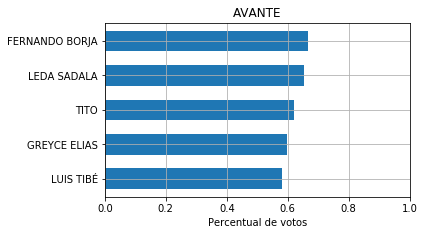

CIDADANIA


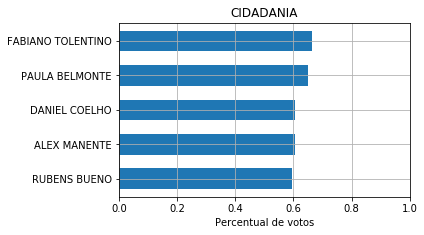

DEM


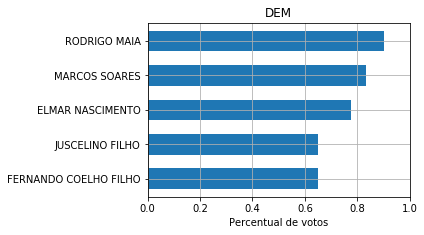

MDB


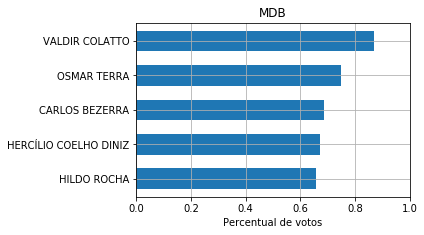

NOVO


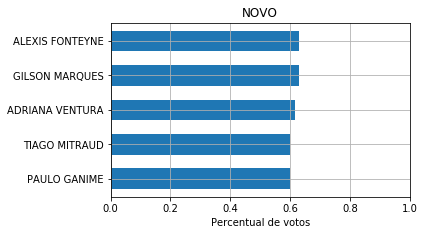

PATRI


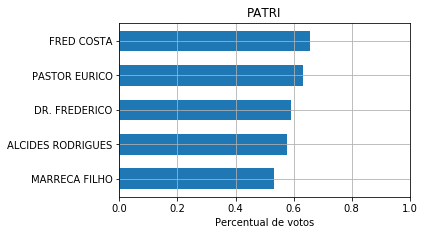

PCDOB


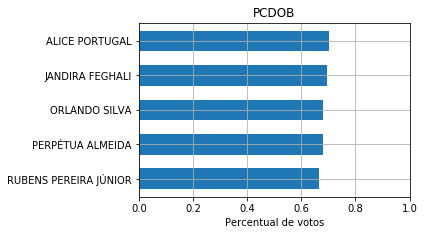

PDT


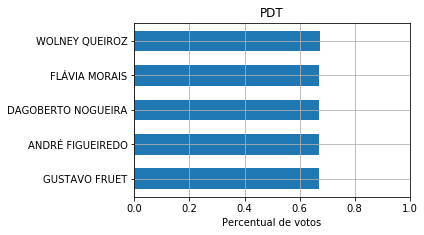

PHS


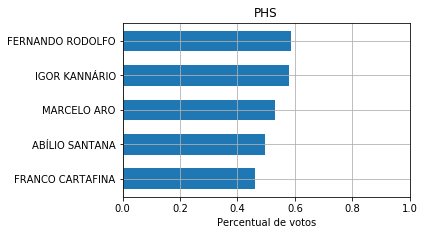

PL


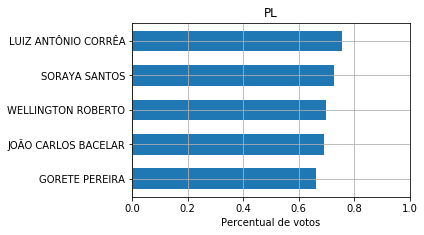

PMN


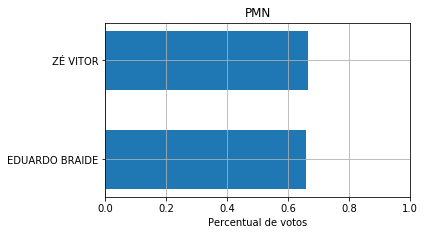

PODE


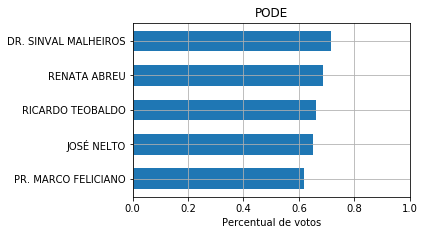

PP


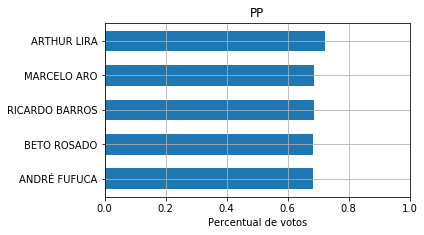

PRB


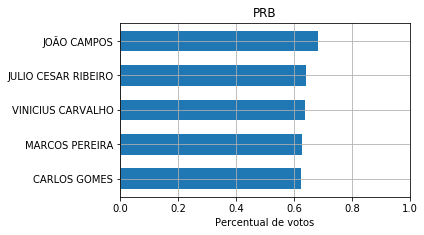

PROS


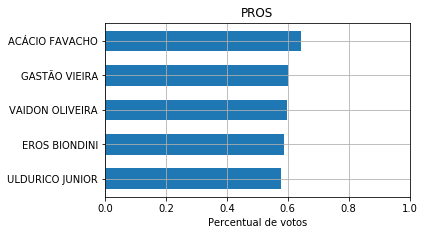

PRP


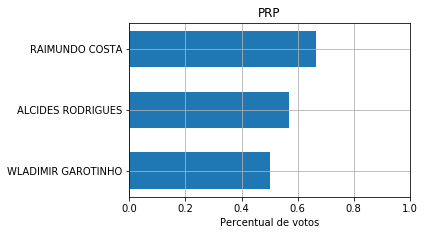

PSB


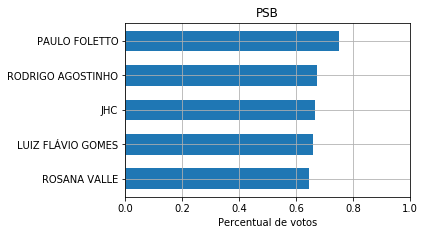

PSC


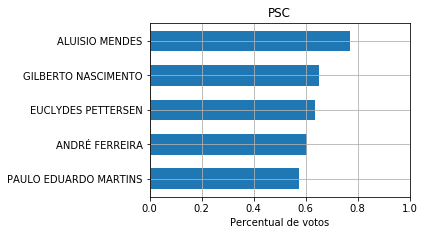

PSD


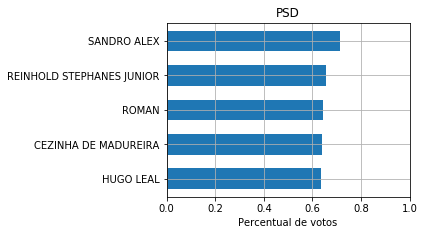

PSDB


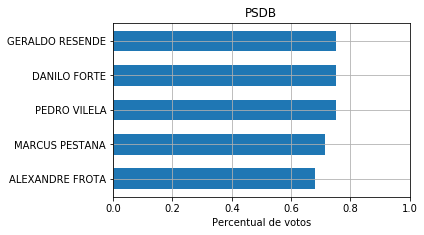

PSL


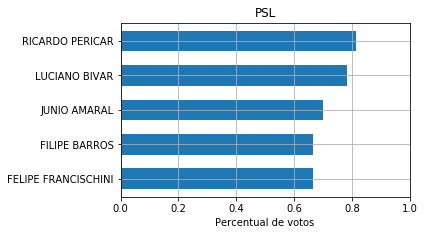

PSOL


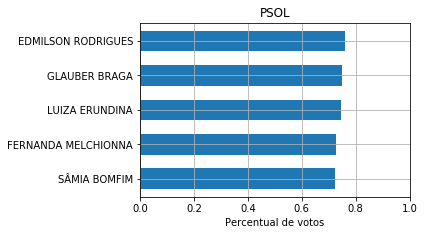

PT


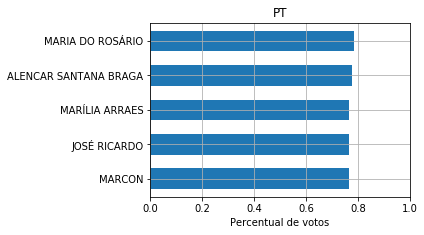

PTB


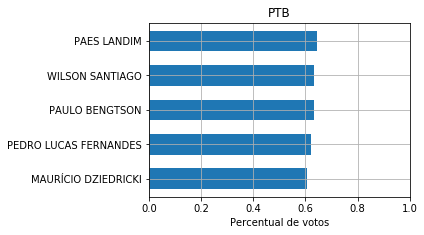

PTC


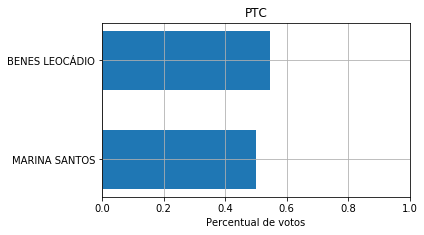

PV


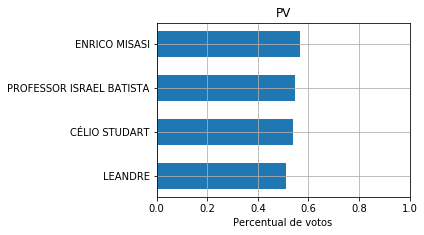

In [26]:
for i in sorted(list(set(df_votos6['Partido']))):
    dfk = df_votos6.query('Partido=="'+i+'"').sort_values(['Percentual'], ascending=False)[:5]
    dfk = dfk.sort_values(['Percentual'], ascending=True)
    print(i)
    width = 0.6
    fig = plt.figure(figsize=(6,3))
    plt.barh(dfk['Parlamentar'], dfk['Percentual'], width)
    plt.grid()
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.title(i)
    plt.xlabel('Percentual de votos')
    plt.show()

Percentual de votos de cada deputado semelhante a maioria dos votos do total de membros do partido

In [27]:
partido = 'PTB'
df_votos6.query("Partido=='"+str.upper(partido)+"'").sort_values(['Percentual'], ascending=False)

,Partido,Parlamentar,Não,Sim,Percentual
1028,PTB,PAES LANDIM,582.0,1053.0,0.644037
1040,PTB,WILSON SANTIAGO,894.0,1543.0,0.633156
1029,PTB,PAULO BENGTSON,771.0,1322.0,0.631629
1033,PTB,PEDRO LUCAS FERNANDES,829.0,1363.0,0.621807
1024,PTB,MAURÍCIO DZIEDRICKI,748.0,1151.0,0.606108
1027,PTB,NIVALDO ALBUQUERQUE,1043.0,1598.0,0.605074
1014,PTB,EMANUEL PINHEIRO NETO,1038.0,1534.0,0.596423
1021,PTB,LUISA CANZIANI,808.0,1149.0,0.587123
1037,PTB,SANTINI,1071.0,1516.0,0.586007
1013,PTB,EDUARDO COSTA,996.0,1388.0,0.582215
